rotation_dataset/
├── train/
│   ├── 0/
│   ├── 90/
│   ├── 180/
│   └── 270/
├── val/
│   ├── 0/
│   ├── 90/
│   └── ...


In [22]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
from torchvision.models import resnet18

import torch.optim as optim
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




Using device: cpu


In [19]:
from collections import Counter

def summarize_dataset(dataset, name="dataset"):
    class_counts = Counter([label for _, label in dataset.samples])
    class_names = dataset.classes

    print(f"📊 {name.upper()} SET SUMMARY:")
    print(f"Total images: {len(dataset)}")
    for idx, count in sorted(class_counts.items()):
        print(f"  Class '{class_names[idx]}': {count} images")
    print()


In [12]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # or (128, 128) for speed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = ImageFolder("../data/rotation/classification/train", transform=transform)
val_data = ImageFolder("../data/rotation/classification/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

In [20]:
train_data = ImageFolder("../data/rotation/classification/train", transform=transform)
val_data = ImageFolder("../data/rotation/classification/test", transform=transform)

summarize_dataset(train_data, name="train")
summarize_dataset(val_data, name="test")


📊 TRAIN SET SUMMARY:
Total images: 386
  Class '0': 73 images
  Class '180': 75 images
  Class '270': 73 images
  Class '45': 88 images
  Class '90': 77 images

📊 TEST SET SUMMARY:
Total images: 115
  Class '0': 27 images
  Class '180': 25 images
  Class '270': 27 images
  Class '45': 13 images
  Class '90': 23 images



In [13]:


# Load pre-trained ResNet-18
model = resnet18(pretrained=True)

# Replace final layer to match number of angles
model.fc = nn.Linear(model.fc.in_features, len(train_data.classes))  # auto-adjust to #classes

model = model.to(device)


In [25]:
os.makedirs("checkpoints", exist_ok=True)

In [26]:
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    start_time = time.time()
    model.train()
    
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # 🔍 Training accuracy
    train_acc = 100 * correct_train / total_train

    # 🧪 Validation accuracy
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    val_acc = 100 * correct_val / total_val

    # ⏱️ Epoch time
    elapsed = time.time() - start_time

    print(f"Epoch {epoch+1:02d} | Loss: {total_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | "
          f"Time: {elapsed:.1f}s")
    
    
    torch.save(model.state_dict(), f"checkpoints/model_epoch_{epoch+1:02d}.pth")



Epoch 01 | Loss: 4.2621 | Train Acc: 98.19% | Val Acc: 93.04% | Time: 16.7s


KeyboardInterrupt: 

✅ Overall Accuracy: 92.17%

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91        27
         180       0.84      0.84      0.84        25
         270       1.00      0.93      0.96        27
          45       0.81      1.00      0.90        13
          90       1.00      1.00      1.00        23

    accuracy                           0.92       115
   macro avg       0.92      0.93      0.92       115
weighted avg       0.93      0.92      0.92       115



/var/folders/0n/jq4hk2n95c51k_c9nh0xpnrc0000gn/T/ipykernel_99690/2740231547.py:49: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/gerhardkarbeutz/cerpro/ocr-rec-lab/ocr-rec-lab-venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


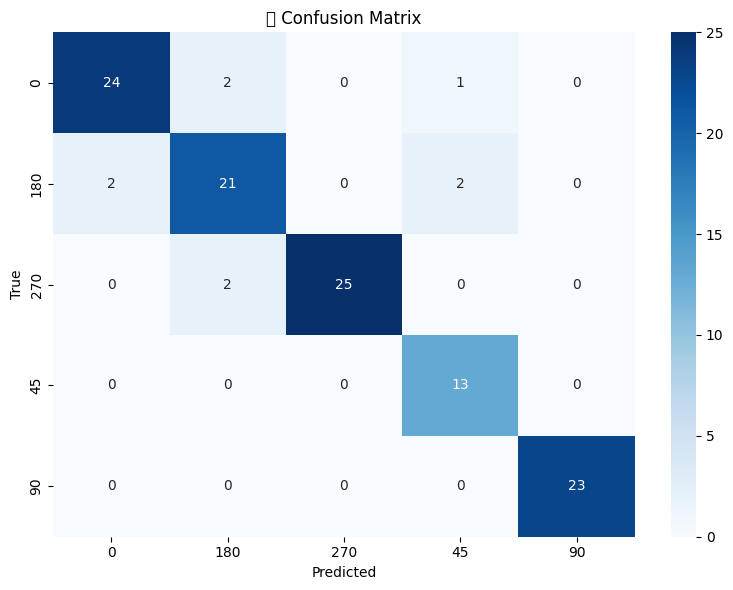

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set model to evaluation mode
model.eval()

# Store true and predicted labels
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -----------------------------
# 🎯 Overall Accuracy
# -----------------------------
correct = sum(np.array(all_preds) == np.array(all_labels))
total = len(all_labels)
accuracy = 100 * correct / total
print(f"✅ Overall Accuracy: {accuracy:.2f}%")

# -----------------------------
# 📈 Classification Report
# -----------------------------
class_names = train_data.classes  # taken from folder names
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# -----------------------------
# 📉 Confusion Matrix
# -----------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("🌀 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
